# RELATION OF THE XCT COMPUTED TOMOGRAPHY WITH THE ULTRASOUND PULSE ECHO
## **Predicting porosity void fraction in unseen data using the attenuation**
### Part 3/X 

### **GOAL**
1. Develop a lineal model to estimate the void fraction in unseen data.
    * Estimate the porosity with window = 3mm^2
    * Estimate the porosity with window = 5mm^2

## **MATERIALS AND DATA**
There are two origins: data from the reconstructed XCT volume and the features of the ultrasound volume.
* Ultrasounds data: The attenuation C-scan measured in pulse-eco. 
XCT Scan
* XCT porosity projection with sime equal as the ultrasound.

*Note: Window sizes of 3x3 and 5x5 due to previous experiments*

## LIBRARIES 

In [2]:
# Mathematical
import scipy
import skimage
import numpy as np
import pandas as pd

import sklearn as skl
import sklearn.metrics
import sklearn.linear_model
import sklearn.tree
import sklearn.metrics
import sklearn.model_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.preprocessing
from sklearn.utils import shuffle

# Operational
# import importlib
from pathlib import Path
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
import napari
from napari.utils import nbscreenshot
%gui qt5

## **ANALYSIS**

## **1. Develop a lineal model to estimate the void fraction in unseen data.**

### Loading dataframes

In [3]:
path_to_dfs_c4567 = Path(r"D:\OneDrive - Universidad Politécnica de Madrid\2_Tareas\20201210_Models_c24567\filter_dataframes")

df_c4_w3 =  pd.read_csv(path_to_dfs_c4567 / 'df_fil13coupon4_w3.csv')
df_c5_w3 =  pd.read_csv(path_to_dfs_c4567 / 'df_fil13coupon5_w3.csv')
df_c6_w3 =  pd.read_csv(path_to_dfs_c4567 / 'df_fil13coupon6_w3.csv')
df_c7_w3 =  pd.read_csv(path_to_dfs_c4567 / 'df_fil13coupon7_w3.csv')

df_c4_w5 =  pd.read_csv(path_to_dfs_c4567 / 'df_fil13coupon4_w5.csv')
df_c5_w5 =  pd.read_csv(path_to_dfs_c4567 / 'df_fil13coupon5_w5.csv')
df_c6_w5 =  pd.read_csv(path_to_dfs_c4567 / 'df_fil13coupon6_w5.csv')
df_c7_w5 =  pd.read_csv(path_to_dfs_c4567 / 'df_fil13coupon7_w5.csv')


### Displaying images 

In [4]:
## Visualization tool
# The first image of each coupon is the 
viewer = napari.Viewer()

# Images
c4_shape = (154,37)
c5_shape = (154,38)
c6_shape = (151,37)
c7_shape = (151,39)

l_df_cx = [df_c7_w3,
           df_c7_w5]

for i,df in enumerate(l_df_cx):
    att_cscan = df['att_12'].to_numpy().reshape(c7_shape)
    porosity_xct = df['porosity'].to_numpy().reshape(c7_shape)
    viewer.add_image(att_cscan)
    viewer.add_image(porosity_xct).translate = (0,i*45+45)

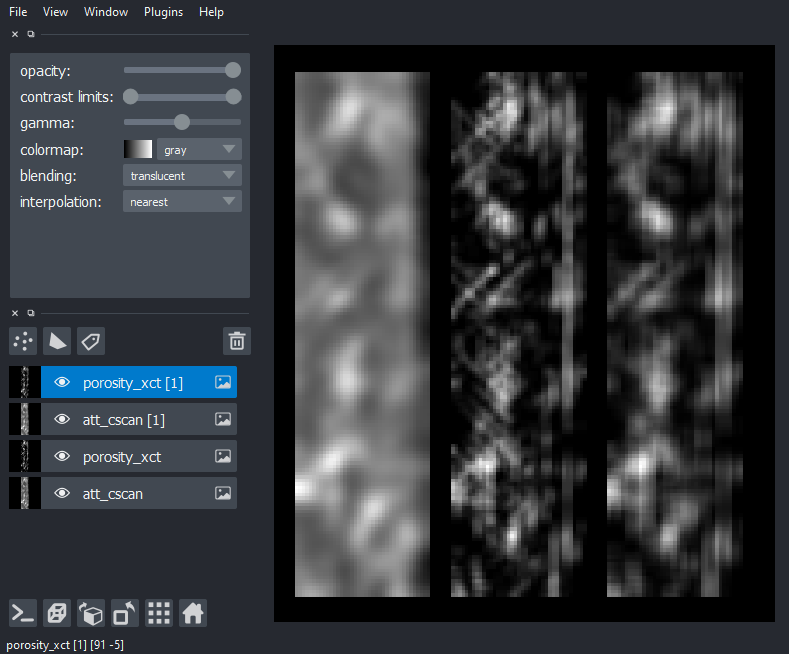

In [7]:
## Coupon 7
nbscreenshot(viewer)

## **Window = 3 mm2**

## Approach
The goal is to inspect the viability of estimating the porosity void fraction in unseen data. Therefore,  the approach considers that three out of the 4 coupons are the training dataset. Once the lineal model is trained it is evaluated in the fourth coupon, that works as evaluation dataset.  

### Forming training dataset

In [5]:
# In this case the training dataset are the registers of coupon 4,5 and 6. Evalution is performed in 7.
df_c456_w3 = pd.concat([df_c4_w3[['att_12','porosity']],
                        df_c5_w3[['att_12','porosity']],
                        df_c6_w3[['att_12','porosity']]],ignore_index=True)
print(df_c456_w3.shape)
df_c456_w3.head() 

(17137, 2)


,att_12,porosity
0,13.589546,0.672934
1,13.133774,0.336467
2,12.696093,0.000000
3,12.443919,0.000000
4,12.889033,0.000000


### Creating model and its hyperparameters 

In [8]:
linr = skl.linear_model.LinearRegression(normalize=False,fit_intercept=True)

### Training the model
A cross-validation methodology with 5 folds was chosen to measure the homogenity of the training process 

In [10]:
df = df_c456_w3
X_train = df['att_12']
y_train = df['porosity']

X_test = df_c7_w3['att_12']
y_test = df_c7_w3['porosity']

linr_scores_att = skl.model_selection.cross_validate(linr,
                                                         X_train.to_numpy().reshape((-1,1)),
                                                         y_train,
                                                         cv=5,
                                                         return_estimator=True)
pd.DataFrame({'Test score': linr_scores_att['test_score']})

,Test score
0,0.548903
1,0.627929
2,0.609485
3,0.722694
4,0.603938


There is a variation of almost 0.2 among folds. It can be more homogenous if data are shuffled so registers are no longer ordered by location and coupon

In [228]:
df = shuffle(df_c456_w3.copy())
X_train = df['att_12']
y_train = df['porosity']
linr_scores_att = skl.model_selection.cross_validate(linr,
                                                         X_train.to_numpy().reshape((-1,1)),
                                                         y_train,
                                                         cv=5,
                                                         return_estimator=True)
pd.DataFrame({'Test score': linr_scores_att['test_score']})

,Test score
0,0.651634
1,0.651582
2,0.651435
3,0.650883
4,0.626731


### Perform estimation and evaluation in unseen data

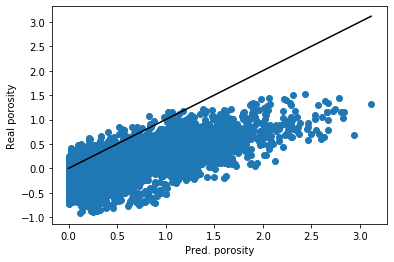

In [11]:
# In this case the unseen data are the registers of coupon 7

## Predinting
# One estimator of the cross validation is chosen
fold = 0
lineal_model = linr_scores_att['estimator'][fold]
df_test = df_c7_w3
attenuation = df_test['att_12'].to_numpy().reshape(-1,1)
pred_porosity = lineal_model.predict(attenuation)

plt.scatter(df_test['porosity'],pred_porosity)
plt.ylabel('Real porosity')
plt.xlabel('Pred. porosity')
plt.plot([0,np.max(df_test['porosity'])],[0,np.max(df_test['porosity'])],'black')
plt.show()

<div style="background-color: LightYellow; border-color: Orange; padding: 0.5em;">

### Some comments
It was mentioned in the previous experiments that coupon 7, the evaluation dataset, had a different behaviour than the rest of coupons. It is not a surprise that the model fit with the other coupons data does not perform well.

An interesting option for the evaluation consists in displaying the prediction and the error as images. This way it is possible to locate the registers where the model is estimating better. 
      </ol>
    </div>

In [230]:
## Error measurement
df_error = pd.DataFrame(X_test)
df_error['porosity'] = y_test

# Saving porosity predictions
df_error['att_pred_porosity'] = pred_porosity

# Computing error as a difference of "y" and pred_y and absolute error
df_error['att_lineal_error'] = df_error['porosity'] - df_error['att_pred_porosity']

df_error['att_abs_lineal_error'] = np.abs(df_error['porosity'] - df_error['att_pred_porosity'])


## Visualization
def plot_feat_maps(feat_maps):
    viewer = napari.Viewer()
    
    for tupla in feat_maps:
        viewer.add_image(tupla[1],name=tupla[0])
    return viewer

feat_maps = [] 
for column in df_error.iloc[:,:]:
    feat_maps.append( (column, df_error[column].to_numpy().reshape(c7_shape)) )
error_viewer = plot_feat_maps(feat_maps)

<div style="background-color: LightYellow; border-color: LightYellow; border-left: 5px solid Orange; padding: 0.5em;">    <strong>RESULTS:</strong> 
</div>

### ABSOLUTE ERROR IMAGE

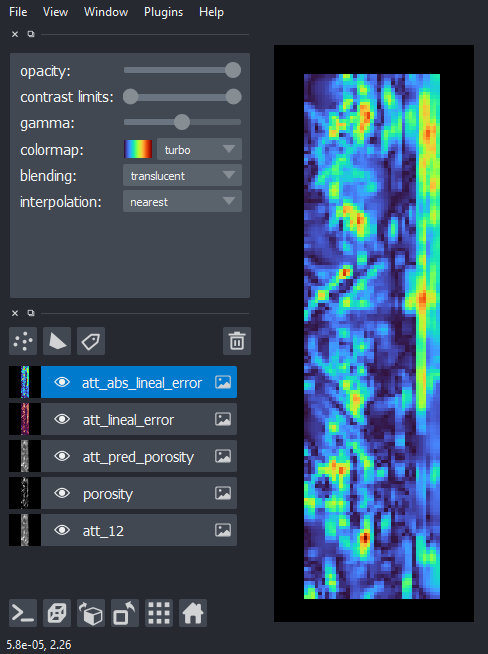

In [206]:
# Applied a colormap = Turbo
nbscreenshot(error_viewer)

In [231]:
df_error.describe()

,att_12,porosity,att_pred_porosity,att_lineal_error,att_abs_lineal_error
count,5889.000000,5889.000000,5889.000000,5889.000000,5889.000000
mean,10.513537,0.547984,0.176539,0.371445,0.399995
std,2.958019,0.521634,0.322213,0.387635,0.358096
min,0.885903,0.000000,-0.872186,-0.428025,0.000008
25%,8.747858,0.124808,-0.015794,0.083456,0.117518
50%,10.286616,0.401596,0.151821,0.279733,0.285960
75%,12.159255,0.839899,0.355805,0.604391,0.604391
max,22.963123,3.117313,1.532656,2.240692,2.240692


### *absolute error img = abs(real porosity - predicted porosity)*

<div style="background-color: LightYellow; border-color: Orange; border-left: 5px solid Orange; padding: 0.5em;">
    Results regarding the absolute error image: 
    <ul>
        <li> <strong>Median absolute error</strong> The model yields for the 50% of the registers an absolute error below the 0.3% of porosity.   
        <li> <strong>Error distribution</strong> The greater error is located at the high void fraction areas.
    </ul>
    </div>

### DIFFERENCE ERROR IMAGE

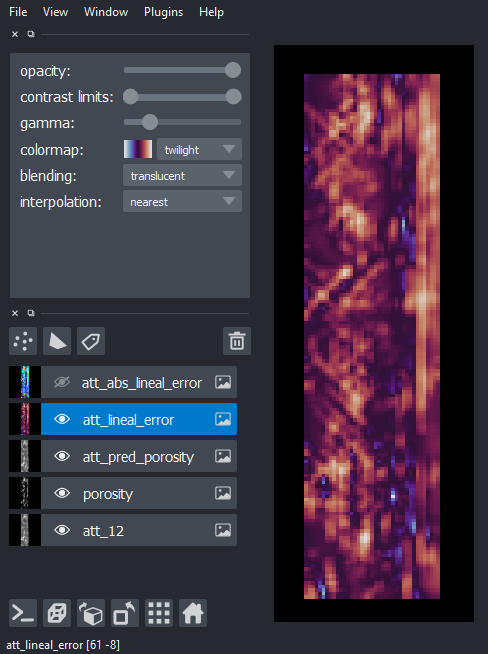

In [208]:
# Applied a colormap = twilight, pay attention that this colour map is white at the extremes and
# black in the middle point.
# gamma manually adjusted so registers with value = 0 are represented with black 
nbscreenshot(error_viewer)

### *difference error img = real porosity - predicted porosity*

<div style="background-color: LightYellow; border-color: Orange; border-left: 5px solid Orange; padding: 0.5em;">
    Results regarding the difference error image: 
    <ul>
    <strong>Error distribution</strong>
        <li> Most of the difference error registers are positive, only 25% of them are below 0. The real porosity is greater than the predicted, therefore, the model is underestimating. The registers with positive error are displayed with an orangish tone.
        <li> If the predicted porosity is greater than the real, the model overestimates. This is the case for the bluish registers, mostly located at the bottom part of the image
    </ul>
    </div>

---------
## Repeating above process with coupon 4 as evaluation dataset

   Test score
0    0.488661
1    0.494095
2    0.482507
3    0.468549
4    0.486969


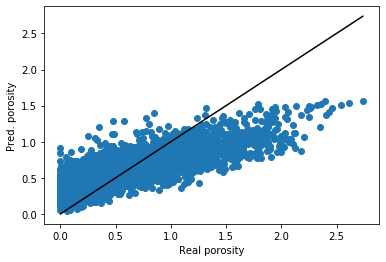

In [5]:
## Dataset definition
df_c567_w3 = pd.concat([df_c5_w3[['att_12','porosity']],
                        df_c6_w3[['att_12','porosity']],
                        df_c7_w3[['att_12','porosity']]],ignore_index=True)
df_train = shuffle(df_c567_w3.copy())
X_train = df_train['att_12']
y_train = df_train['porosity']

df_test = df_c4_w3
X_test = df_test['att_12']
y_test = df_test['porosity']

## Model definition
linr = skl.linear_model.LinearRegression(normalize=False,fit_intercept=True)
linr_scores_att = skl.model_selection.cross_validate(linr,
                                                         X_train.to_numpy().reshape((-1,1)),
                                                         y_train,
                                                         cv=5,
                                                         return_estimator=True)
test_scores = pd.DataFrame({'Test score': linr_scores_att['test_score']})
print(test_scores)

## Predicting
# One estimator of the cross validation is chosen
fold = 0
lineal_model = linr_scores_att['estimator'][fold]
attenuation = df_test['att_12'].to_numpy().reshape(-1,1)
pred_porosity = lineal_model.predict(attenuation)


## Visualization
plt.scatter(df_test['porosity'],pred_porosity)
plt.xlabel('Real porosity')
plt.ylabel('Pred. porosity')
plt.plot([0,np.max(df_test['porosity'])],[0,np.max(df_test['porosity'])],'black')
plt.show()


## Error measurement
# Dataset
df_error = pd.DataFrame(X_test)
df_error['porosity'] = y_test

# Saving porosity predictions
df_error['att_pred_porosity'] = pred_porosity

# Computing error as a difference of "y" and pred_y and absolute error
df_error['att_lineal_error'] = df_error['porosity'] - df_error['att_pred_porosity']
df_error['att_abs_lineal_error'] = np.abs(df_error['porosity'] - df_error['att_pred_porosity'])


## Visualization
def plot_feat_maps(feat_maps):
    viewer = napari.Viewer()
    
    for tupla in feat_maps:
        viewer.add_image(tupla[1],name=tupla[0])
    return viewer

feat_maps = [] 
for column in df_error.iloc[:,:]:
    feat_maps.append( (column, df_error[column].to_numpy().reshape(c4_shape)) )
error_viewer4 = plot_feat_maps(feat_maps)

<div style="background-color: LightYellow; border-color: Orange; padding: 0.5em;">

### Graphic of Real versus Predicted porosity
In previous notebooks coupon had a slithly different lineal fit than the rest of coupons. However, theif the model fit for the rest of coupons is applied in 4 the results are a large underestimation of void fraction in the high concentration areas.

Recurring again to the the error images as the evaluation methodology.
      </ol>
    </div>

### Saving error Images

In [15]:
def save_imagen(array, pathlibpath,tipo,norm=False):
    if (norm == True):
        array = skimage.img_as_ubyte(skimage.exposure.rescale_intensity(array))
        imagen = Image.fromarray(array)
    else:
        imagen = Image.fromarray(array.astype(tipo))
    imagen.save(pathlibpath) 

def save_feat_maps(feat_maps,pathlibpath,tipo='float'):
    for tupla in feat_maps:
        ruta = pathlibpath / (tupla[0]+'.tif')
        save_imagen(tupla[1],ruta,tipo)
    print('All feature maps saved')
    
save_feat_maps(feat_maps,Path().cwd())

All feature maps saved


<div style="background-color: LightYellow; border-color: LightYellow; border-left: 5px solid Orange; padding: 0.5em;">    <strong>RESULTS:</strong> 
</div>

### ABSOLUTE ERROR IMAGE

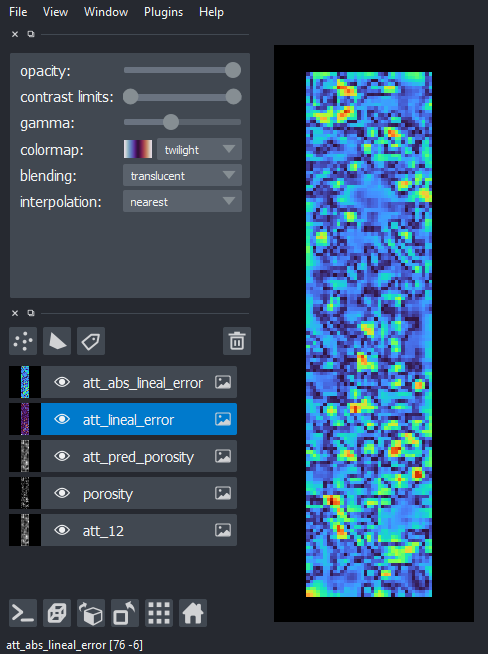

In [221]:
# Applied a colormap = Turbo
nbscreenshot(error_viewer4)

In [225]:
df_error.describe()

,att_12,porosity,att_pred_porosity,att_lineal_error,att_abs_lineal_error
count,5698.000000,5698.000000,5698.000000,5698.000000,5698.000000
mean,13.306586,0.572176,0.591812,-0.019637,0.241424
std,2.791252,0.460323,0.233766,0.301306,0.181316
min,6.714654,0.000000,0.039741,-0.913359,0.000062
25%,11.272526,0.193979,0.421461,-0.234296,0.108885
50%,12.977739,0.479003,0.564271,-0.080993,0.209894
75%,15.032146,0.846073,0.736327,0.153623,0.326628
max,25.047876,2.737588,1.575140,1.299751,1.299751


### *absolute error img = abs(real porosity - predicted porosity)*

<div style="background-color: LightYellow; border-color: Orange; border-left: 5px solid Orange; padding: 0.5em;">
    Results regarding the absolute error image: 
    <ul>
        <li> <strong>Low absolute error</strong> A 75% of the pixels are below the 0.32% of error (in blue),  registers with 0.5% are green, 0.7% are yellowish and 1% or more are red.
        <li> <strong>Error distribution</strong> Again, the greater error is located at the high void fraction areas.
    </ul>
    </div>

### DIFFERENCE ERROR IMAGE

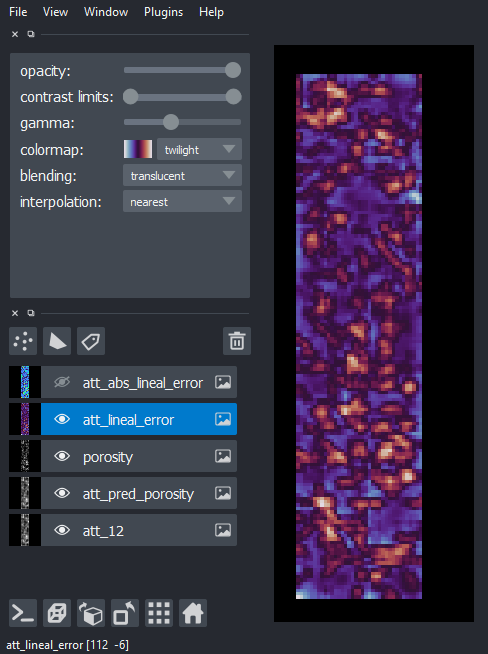

In [233]:
# Applied a colormap = twilight, pay attention that this colour map is white at the extremes and
# black in the middle point.
# gamma manually adjusted so registers with value = 0 are represented with black 
nbscreenshot(error_viewer4)

### *difference error img = real porosity - predicted porosity*

<div style="background-color: LightYellow; border-color: Orange; border-left: 5px solid Orange; padding: 0.5em;">
    Results regarding the difference error image: 
    <ul>
    <strong>Error distribution</strong>
        <li> In this case the difference error is more balanced than for the coupon 7, the median is very close to 0 (-0.07%). The orangish and blueish pixels are distributed along all the image.
        <li> The model is overestimating for the low porosity area, whereas it is underestimating for the high concentration ones.
    </ul>
    </div>

---------
## PROCESS WITH WINDOW = 5x5mm2
Coupon 7

   Test score
0    0.754305
1    0.757033
2    0.764606
3    0.747107
4    0.760013


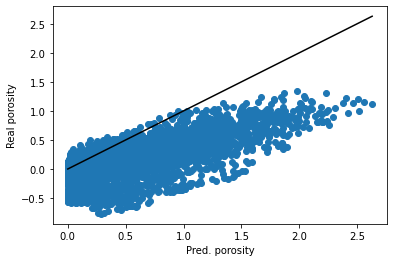

In [236]:
## Dataset definition
df_c456_w5 = pd.concat([df_c4_w5[['att_12','porosity']],
                        df_c5_w5[['att_12','porosity']],
                        df_c6_w5[['att_12','porosity']]],ignore_index=True)
df_train = shuffle(df_c456_w5.copy())
X_train = df_train['att_12']
y_train = df_train['porosity']

df_test = df_c7_w5
X_test = df_test['att_12']
y_test = df_test['porosity']

## Model definition
linr_scores_att = skl.model_selection.cross_validate(linr_att,
                                                         X_train.to_numpy().reshape((-1,1)),
                                                         y_train,
                                                         cv=5,
                                                         return_estimator=True)
test_scores = pd.DataFrame({'Test score': linr_scores_att['test_score']})
print(test_scores)

## Predicting
# One estimator of the cross validation is chosen
fold = 0
lineal_model = linr_scores_att['estimator'][fold]
attenuation = df_test['att_12'].to_numpy().reshape(-1,1)
pred_porosity = lineal_model.predict(attenuation)


## Visualization
plt.scatter(df_test['porosity'],pred_porosity)
plt.ylabel('Real porosity')
plt.xlabel('Pred. porosity')
plt.plot([0,np.max(df_test['porosity'])],[0,np.max(df_test['porosity'])],'black')
plt.show()


## Error measurement
# Dataset
df_error = pd.DataFrame(X_test)
df_error['porosity'] = y_test

# Saving porosity predictions
df_error['att_pred_porosity'] = pred_porosity

# Computing error as a difference of "y" and pred_y and absolute error
df_error['att_lineal_error'] = df_error['porosity'] - df_error['att_pred_porosity']
df_error['att_abs_lineal_error'] = np.abs(df_error['porosity'] - df_error['att_pred_porosity'])


## Visualization
def plot_feat_maps(feat_maps):
    viewer = napari.Viewer()
    
    for tupla in feat_maps:
        viewer.add_image(tupla[1],name=tupla[0])
    return viewer

feat_maps = [] 
for column in df_error.iloc[:,:]:
    feat_maps.append( (column, df_error[column].to_numpy().reshape(c7_shape)) )
error_viewer7 = plot_feat_maps(feat_maps)

<div style="background-color: LightYellow; border-color: Orange; padding: 0.5em;">

### Graphic of Real versus Predicted porosity
Larger window does not improve the lineal model, still most of the registers are underestimating.

Recurring again to the the error images as the evaluation methodology.
      </ol>
    </div>

<div style="background-color: LightYellow; border-color: LightYellow; border-left: 5px solid Orange; padding: 0.5em;">    <strong>RESULTS:</strong> 
</div>

### ABSOLUTE ERROR IMAGE

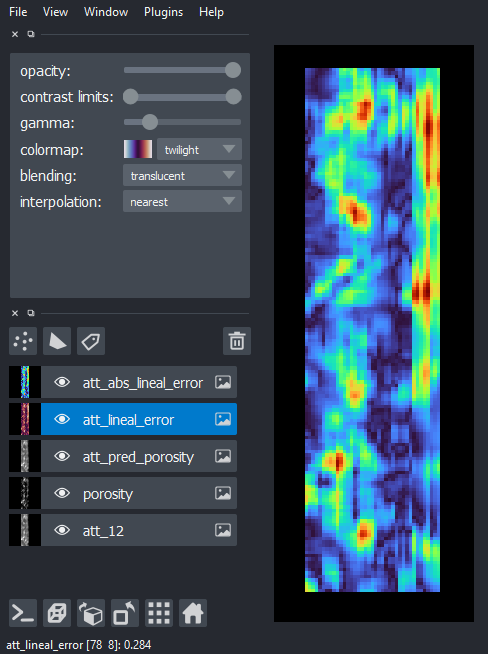

In [237]:
# Applied a colormap = Turbo
nbscreenshot(error_viewer7)

In [6]:
df_error.describe()

,att_12,porosity,att_pred_porosity,att_lineal_error,att_abs_lineal_error
count,5698.000000,5698.000000,5698.000000,5698.000000,5698.000000
mean,13.306586,0.572176,0.588989,-0.016814,0.241227
std,2.791252,0.460323,0.233000,0.301668,0.181895
min,6.714654,0.000000,0.038726,-0.909482,0.000012
25%,11.272526,0.193979,0.419196,-0.231887,0.109664
50%,12.977739,0.479003,0.561539,-0.078547,0.208867
75%,15.032146,0.846073,0.733031,0.156566,0.325251
max,25.047876,2.737588,1.569096,1.303521,1.303521


### *absolute error img = abs(real porosity - predicted porosity)*

<div style="background-color: LightYellow; border-color: Orange; border-left: 5px solid Orange; padding: 0.5em;">
    Results regarding the absolute error image window =5x5mm2: 
    <ul>
        <li> <strong>Comparison with window = 3x3mm2</strong> The error distribution is very similar to the one resulted of applying the window of 3x3mm2.
    </ul>
    </div>

### DIFFERENCE ERROR IMAGE

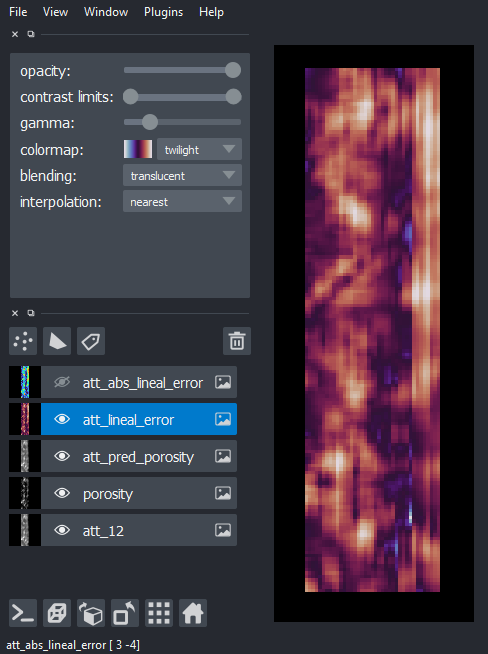

In [241]:
# Applied a colormap = twilight, pay attention that this colour map is white at the extremes and
# black in the middle point.
# gamma manually adjusted so registers with value = 0 are represented with black 
nbscreenshot(error_viewer7)

### *difference error img = real porosity - predicted porosity*

<div style="background-color: LightYellow; border-color: Orange; border-left: 5px solid Orange; padding: 0.5em;">
    Results regarding the difference error image of coupon 7 window = 5x5mm2: 
    <ul>
    <strong>Error distribution</strong>
        <li> The results are very similar to the 3x3mm2. However, the increase in window size affects mostly in the distribution of porosity by making it more homogenous. (Previous notebook) This implies that the model is overestimating and underestimating less than for the case of 3x3mm2. 
    </ul>
    </div>

-----------
### PROCESS WITH WINDOW = 5x5mm2
Evaluation in Coupon 4

   Test score
0    0.569029
1    0.550413
2    0.537751
3    0.536024
4    0.540986


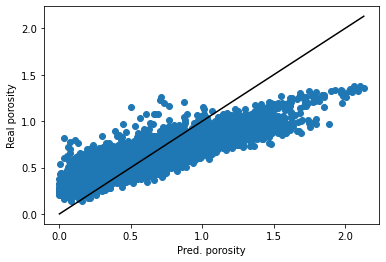

In [245]:
## Dataset definition
df_c567_w5 = pd.concat([df_c5_w5[['att_12','porosity']],
                        df_c6_w5[['att_12','porosity']],
                        df_c7_w5[['att_12','porosity']]],ignore_index=True)
df_train = shuffle(df_c567_w5.copy())
X_train = df_train['att_12']
y_train = df_train['porosity']

df_test = df_c4_w5
X_test = df_test['att_12']
y_test = df_test['porosity']

## Model definition
linr_scores_att = skl.model_selection.cross_validate(linr_att,
                                                         X_train.to_numpy().reshape((-1,1)),
                                                         y_train,
                                                         cv=5,
                                                         return_estimator=True)
test_scores = pd.DataFrame({'Test score': linr_scores_att['test_score']})
print(test_scores)

## Predicting
# One estimator of the cross validation is chosen
fold = 0
lineal_model = linr_scores_att['estimator'][fold]
attenuation = df_test['att_12'].to_numpy().reshape(-1,1)
pred_porosity = lineal_model.predict(attenuation)


## Visualization
plt.scatter(df_test['porosity'],pred_porosity)
plt.ylabel('Real porosity')
plt.xlabel('Pred. porosity')
plt.plot([0,np.max(df_test['porosity'])],[0,np.max(df_test['porosity'])],'black')
plt.show()


## Error measurement
# Dataset
df_error = pd.DataFrame(X_test)
df_error['porosity'] = y_test

# Saving porosity predictions
df_error['att_pred_porosity'] = pred_porosity

# Computing error as a difference of "y" and pred_y and absolute error
df_error['att_lineal_error'] = df_error['porosity'] - df_error['att_pred_porosity']
df_error['att_abs_lineal_error'] = np.abs(df_error['porosity'] - df_error['att_pred_porosity'])


## Visualization
def plot_feat_maps(feat_maps):
    viewer = napari.Viewer()
    
    for tupla in feat_maps:
        viewer.add_image(tupla[1],name=tupla[0])
    return viewer

feat_maps = [] 
for column in df_error.iloc[:,:]:
    feat_maps.append( (column, df_error[column].to_numpy().reshape(c4_shape)) )
error_viewer4_5 = plot_feat_maps(feat_maps)

### ABSOLUTE ERROR IMAGE

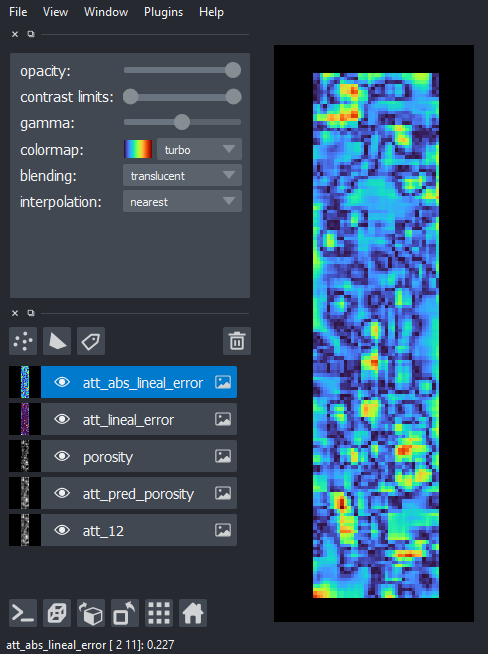

In [246]:
# Applied a colormap = Turbo
nbscreenshot(error_viewer4_5)

In [247]:
df_error.describe()

,att_12,porosity,att_pred_porosity,att_lineal_error,att_abs_lineal_error
count,5698.000000,5698.000000,5698.000000,5698.000000,5698.000000
mean,13.306586,0.572176,0.592627,-0.020452,0.179697
std,2.576833,0.379271,0.201206,0.223590,0.134588
min,7.524625,0.000000,0.141156,-0.780835,0.000014
25%,11.425482,0.271364,0.445746,-0.184022,0.077355
50%,13.002520,0.519730,0.568885,-0.055196,0.156949
75%,14.948941,0.792106,0.720867,0.108734,0.248124
max,23.325341,2.130222,1.374918,0.916927,0.916927


### DIFFERENCE ERROR IMAGE

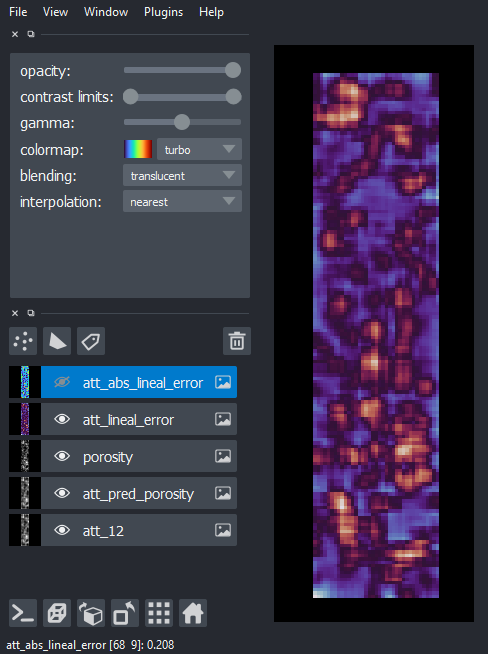

In [249]:
# Applied a colormap = twilight, pay attention that this colour map is white at the extremes and
# black in the middle point.
# gamma manually adjusted so registers with value = 0 are represented with black 
nbscreenshot(error_viewer4_5)

### *difference error img = real porosity - predicted porosity*

-------------------

### **1.CONCLUSIONS FOR THE ESTIMATION OF VOID FRACTION IN UNSEEN DATA**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    
* It is possible to use the data of measured coupons to elaborate a lineal model to estimate the void fraction in new unseen data.
    
* The accuracy is that a majority of registers have an estimation with an absolute error below 0.3%. But there are extremes where this value peaks to more than 1%.

* The type of porosity of the unseen coupon and its similarity with the training dataset are the most important factors. Generally the lineal model tends to underestimate in the high concentration porosity areas and overestimate in the low level ones.

* The window size impacts in the distribution of the porosity. At the time of predicting this seems to be reflected with balance, the model reduces the overestimation and underestimation.
    </div>

------------------------
### Cells to check the other coupons as evaluation dataset

   Test score
0    0.464471
1    0.489052
2    0.506694
3    0.473791
4    0.485146


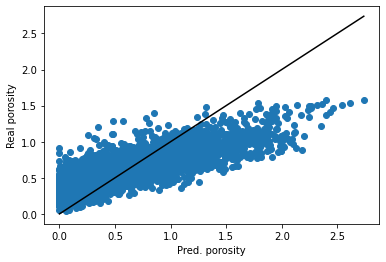

In [219]:
## Dataset definition
df_c567_w3 = pd.concat([df_c5_w3[['att_12','porosity']],
                        df_c6_w3[['att_12','porosity']],
                        df_c7_w3[['att_12','porosity']]],ignore_index=True)
df_train = shuffle(df_c567_w3.copy())
X_train = df_train['att_12']
y_train = df_train['porosity']

df_test = df_c4_w3
X_test = df_test['att_12']
y_test = df_test['porosity']

## Model definition
linr_scores_att = skl.model_selection.cross_validate(linr_att,
                                                         X_train.to_numpy().reshape((-1,1)),
                                                         y_train,
                                                         cv=5,
                                                         return_estimator=True)
test_scores = pd.DataFrame({'Test score': linr_scores_att['test_score']})
print(test_scores)

## Predicting
# One estimator of the cross validation is chosen
fold = 0
lineal_model = linr_scores_att['estimator'][fold]
attenuation = df_test['att_12'].to_numpy().reshape(-1,1)
pred_porosity = lineal_model.predict(attenuation)


## Visualization
plt.scatter(df_test['porosity'],pred_porosity)
plt.ylabel('Real porosity')
plt.xlabel('Pred. porosity')
plt.plot([0,np.max(df_test['porosity'])],[0,np.max(df_test['porosity'])],'black')
plt.show()


## Error measurement
# Dataset
df_error = pd.DataFrame(X_test)
df_error['porosity'] = y_test

# Saving porosity predictions
df_error['att_pred_porosity'] = pred_porosity

# Computing error as a difference of "y" and pred_y and absolute error
df_error['att_lineal_error'] = df_error['porosity'] - df_error['att_pred_porosity']
df_error['att_abs_lineal_error'] = np.abs(df_error['porosity'] - df_error['att_pred_porosity'])


## Visualization
def plot_feat_maps(feat_maps):
    viewer = napari.Viewer()
    
    for tupla in feat_maps:
        viewer.add_image(tupla[1],name=tupla[0])
    return viewer

feat_maps = [] 
for column in df_error.iloc[:,:]:
    feat_maps.append( (column, df_error[column].to_numpy().reshape(c4_shape)) )
error_viewer4 = plot_feat_maps(feat_maps)